In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import shutil

2023-06-05 21:11:18.970305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 21:11:23.934317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Use Xception model:
model = tf.keras.models.load_model('../results/models/model_Xception_imagenet_052223.h5')
#model = tf.keras.models.load_model('../results/models/model_ResNet50_imagenet_050923.h5')

2023-06-05 21:11:40.636411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7962 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 2g.10gb, pci bus id: 0000:21:00.0, compute capability: 8.0


In [3]:
test_dir = '../data/all_frames/vid_20'
img_size = 512
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='categorical', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=1, color_mode='rgb')

Found 492 files belonging to 8 classes.


In [4]:
cols = os.listdir(test_dir)
preds_df = pd.DataFrame(columns=cols)
trues_df = pd.DataFrame(columns=cols)

# for videos with number of classes < 9, we delete some elements in pred to match the size of label:
label_name = os.listdir('../data/all_frames/vid_0')
label_index = [0,1,2,3,4,5,6,7,8]
label_dict = {label_name[i]: label_index[i] for i in range(len(label_name))}
keep_list = [label_dict[i] for i in os.listdir('../data/all_frames/vid_20')]

print(keep_list)

#for each image in the test dataset, get the predicted probability of each class and the true class and the image path
count = 0
for images, labels in test_ds:
    pred = model.predict(images)
    label = labels.numpy()
    pred = pred[0]
    pred = [pred[i] for i in keep_list]
    preds_df.loc[count] = pred
    trues_df.loc[count] = label[0]
    count += 1
print(count)

[0, 1, 2, 3, 4, 5, 7, 8]


2023-06-05 21:11:48.466804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [492]
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:11:48.467023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [492]
	 [[{{node Placeholder/_4}}]]
2023-06-05 21:11:49.935984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801


1/1 [==============================] - 2s 2s/step


2023-06-05 21:11:50.666649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 22ms/step
492


In [5]:
preds_df['path'] = test_ds.file_paths
trues_df['path'] = test_ds.file_paths
preds_df.head()

,eso_mob,exposure,fundus_mob,hiatal_dissec,hiatal_repair,oob,sac_excision,wrap,path
0,0.045474,0.000006,0.000914,0.953590,0.000010,1.106687e-10,0.000006,3.514210e-07,../data/all_frames/vid_20/eso_mob/vid_20_1150.jpg
1,0.573764,0.000010,0.001092,0.395680,0.029172,9.399934e-08,0.000052,1.779203e-04,../data/all_frames/vid_20/eso_mob/vid_20_1160.jpg
2,0.884270,0.000002,0.065966,0.032536,0.000369,9.194511e-09,0.016596,2.369857e-04,../data/all_frames/vid_20/eso_mob/vid_20_1170.jpg
3,0.962925,0.000001,0.000636,0.009635,0.017616,1.964596e-07,0.003843,5.284498e-03,../data/all_frames/vid_20/eso_mob/vid_20_1180.jpg
4,0.786552,0.001523,0.018574,0.124527,0.020374,1.428502e-04,0.025021,2.086992e-02,../data/all_frames/vid_20/eso_mob/vid_20_1190.jpg


In [6]:
trues_df.head(-5)

,eso_mob,exposure,fundus_mob,hiatal_dissec,hiatal_repair,oob,sac_excision,wrap,path
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/all_frames/vid_20/eso_mob/vid_20_1150.jpg
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/all_frames/vid_20/eso_mob/vid_20_1160.jpg
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/all_frames/vid_20/eso_mob/vid_20_1170.jpg
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/all_frames/vid_20/eso_mob/vid_20_1180.jpg
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../data/all_frames/vid_20/eso_mob/vid_20_1190.jpg
...,...,...,...,...,...,...,...,...,...
482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,../data/all_frames/vid_20/wrap/vid_20_4920.jpg
483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,../data/all_frames/vid_20/wrap/vid_20_4930.jpg
484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,../data/all_frames/vid_20/wrap/vid_20_4940.jpg
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,../data/all_frames/vid_20/wrap/vid_20_4950.jpg


In [7]:
#calculate accuracy
preds_mat = preds_df.drop(columns=['path'])
trues_mat = trues_df.drop(columns=['path'])
correct_cnt = 0
for i in range(len(preds_mat)):
    pred = np.argmax((preds_mat.iloc[i]).to_numpy())
    true = np.argmax((trues_mat.iloc[i]).to_numpy())
    if pred==true:
        correct_cnt+=1
print("accuracy: ", correct_cnt/len(preds_mat))

accuracy:  0.9227642276422764


In [8]:
#find top losses for each phase, show the image, the predicted label, and the true label
losses_df = pd.DataFrame(columns=cols)
for phase in cols:
    #get the predicted probability of each class and the true class for the current phase
    preds = preds_df[phase]
    trues = trues_df[phase]
    #calculate the loss for each image
    losses = np.abs(preds - trues)
    #add the losses to the losses_df
    losses_df[phase] = losses
losses_df['path'] = preds_df['path']

In [9]:
preds_df.iloc[170]

eso_mob                                                    0.00001
exposure                                                  0.000084
fundus_mob                                                0.002363
hiatal_dissec                                             0.997543
hiatal_repair                                                  0.0
oob                                                            0.0
sac_excision                                                   0.0
wrap                                                           0.0
path             ../data/all_frames/vid_20/hiatal_dissec/vid_20...
Name: 170, dtype: object

In [10]:
trues_df.iloc[170]

eso_mob                                                        0.0
exposure                                                       0.0
fundus_mob                                                     0.0
hiatal_dissec                                                  1.0
hiatal_repair                                                  0.0
oob                                                            0.0
sac_excision                                                   0.0
wrap                                                           0.0
path             ../data/all_frames/vid_20/hiatal_dissec/vid_20...
Name: 170, dtype: object

In [11]:
losses_df.iloc[170]

eso_mob                                                    0.00001
exposure                                                  0.000084
fundus_mob                                                0.002363
hiatal_dissec                                             0.002457
hiatal_repair                                                  0.0
oob                                                            0.0
sac_excision                                                   0.0
wrap                                                           0.0
path             ../data/all_frames/vid_20/hiatal_dissec/vid_20...
Name: 170, dtype: object

In [12]:
def get_timestamp(path):
    path = path.split('/')[5].split('_')[2].split('.')[0]
    time = int(path)
    hr = math.floor(time/3600)
    mint = math.floor((time-hr*3600)/60)
    sec = time - hr*3600 - mint*60
    return (f"{hr}h:{mint}m:{sec}s")

def get_true(path):
    return path.split('/')[4]

losses1 = losses_df
losses1['time_stamp'] = losses1.apply(lambda row: get_timestamp(row['path']) , axis=1)
losses1['true'] = losses1.apply(lambda row: get_true(row['path']) , axis=1)
losses1.head(10)

,eso_mob,exposure,fundus_mob,hiatal_dissec,hiatal_repair,oob,sac_excision,wrap,path,time_stamp,true
0,0.954526,5.777463e-06,9.137375e-04,0.953590,0.000010,1.106687e-10,5.709985e-06,3.514210e-07,../data/all_frames/vid_20/eso_mob/vid_20_1150.jpg,0h:19m:10s,eso_mob
1,0.426236,9.653042e-06,1.092092e-03,0.395680,0.029172,9.399934e-08,5.191674e-05,1.779203e-04,../data/all_frames/vid_20/eso_mob/vid_20_1160.jpg,0h:19m:20s,eso_mob
2,0.115730,2.020646e-06,6.596614e-02,0.032536,0.000369,9.194511e-09,1.659557e-02,2.369857e-04,../data/all_frames/vid_20/eso_mob/vid_20_1170.jpg,0h:19m:30s,eso_mob
3,0.037075,1.467620e-06,6.361323e-04,0.009635,0.017616,1.964596e-07,3.843436e-03,5.284498e-03,../data/all_frames/vid_20/eso_mob/vid_20_1180.jpg,0h:19m:40s,eso_mob
4,0.213448,1.523321e-03,1.857416e-02,0.124527,0.020374,1.428502e-04,2.502064e-02,2.086992e-02,../data/all_frames/vid_20/eso_mob/vid_20_1190.jpg,0h:19m:50s,eso_mob
5,0.000286,6.101828e-10,1.276851e-07,0.000017,0.000032,3.839551e-08,3.647523e-07,2.367720e-04,../data/all_frames/vid_20/eso_mob/vid_20_1200.jpg,0h:20m:0s,eso_mob
6,0.000531,3.442102e-09,2.713030e-06,0.000025,0.000048,9.309293e-08,1.237444e-06,4.535595e-04,../data/all_frames/vid_20/eso_mob/vid_20_1210.jpg,0h:20m:10s,eso_mob
7,0.026740,5.194896e-07,1.917832e-02,0.007102,0.000157,3.819390e-09,2.249221e-04,7.392462e-05,../data/all_frames/vid_20/eso_mob/vid_20_1220.jpg,0h:20m:20s,eso_mob
8,0.115853,3.639441e-04,1.911488e-03,0.045510,0.041451,2.426509e-05,2.064179e-02,3.400003e-03,../data/all_frames/vid_20/eso_mob/vid_20_1230.jpg,0h:20m:30s,eso_mob
9,0.310528,6.898074e-05,5.633621e-03,0.027304,0.110680,1.314738e-06,1.535587e-01,2.026824e-03,../data/all_frames/vid_20/eso_mob/vid_20_1240.jpg,0h:20m:40s,eso_mob


In [13]:
losses1 = losses1.sort_values(by='hiatal_dissec', ascending=False)
losses1 = losses1[['hiatal_dissec', 'path', 'time_stamp', 'true']]
losses1 = losses1[losses1['true']=='hiatal_dissec']
losses1 = losses1[losses1['hiatal_dissec']>0.5]
losses1

,hiatal_dissec,path,time_stamp,true
141,0.968518,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:18m:10s,hiatal_dissec
150,0.949966,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:21m:50s,hiatal_dissec
151,0.914700,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:22m:0s,hiatal_dissec
153,0.780222,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:33m:30s,hiatal_dissec
174,0.778767,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:13m:30s,hiatal_dissec
142,0.770606,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:18m:20s,hiatal_dissec
155,0.570886,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:33m:50s,hiatal_dissec


In [14]:
preds_df['pred'] = preds_df[trues_df.columns[0:len(preds_df.columns)-1]].idxmax(axis=1)
preds_df.head()

,eso_mob,exposure,fundus_mob,hiatal_dissec,hiatal_repair,oob,sac_excision,wrap,path,pred
0,0.045474,0.000006,0.000914,0.953590,0.000010,1.106687e-10,0.000006,3.514210e-07,../data/all_frames/vid_20/eso_mob/vid_20_1150.jpg,hiatal_dissec
1,0.573764,0.000010,0.001092,0.395680,0.029172,9.399934e-08,0.000052,1.779203e-04,../data/all_frames/vid_20/eso_mob/vid_20_1160.jpg,eso_mob
2,0.884270,0.000002,0.065966,0.032536,0.000369,9.194511e-09,0.016596,2.369857e-04,../data/all_frames/vid_20/eso_mob/vid_20_1170.jpg,eso_mob
3,0.962925,0.000001,0.000636,0.009635,0.017616,1.964596e-07,0.003843,5.284498e-03,../data/all_frames/vid_20/eso_mob/vid_20_1180.jpg,eso_mob
4,0.786552,0.001523,0.018574,0.124527,0.020374,1.428502e-04,0.025021,2.086992e-02,../data/all_frames/vid_20/eso_mob/vid_20_1190.jpg,eso_mob


In [15]:
losses1['pred']=np.nan
for i in range(len(losses1)):
    index= losses1.index[i]
    pred1 = preds_df.loc[index,'pred']
    losses1.loc[index,'pred']=pred1
losses1

,hiatal_dissec,path,time_stamp,true,pred
141,0.968518,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:18m:10s,hiatal_dissec,fundus_mob
150,0.949966,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:21m:50s,hiatal_dissec,eso_mob
151,0.914700,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:22m:0s,hiatal_dissec,eso_mob
153,0.780222,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:33m:30s,hiatal_dissec,eso_mob
174,0.778767,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:13m:30s,hiatal_dissec,fundus_mob
142,0.770606,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:18m:20s,hiatal_dissec,fundus_mob
155,0.570886,../data/all_frames/vid_20/hiatal_dissec/vid_20...,0h:33m:50s,hiatal_dissec,eso_mob


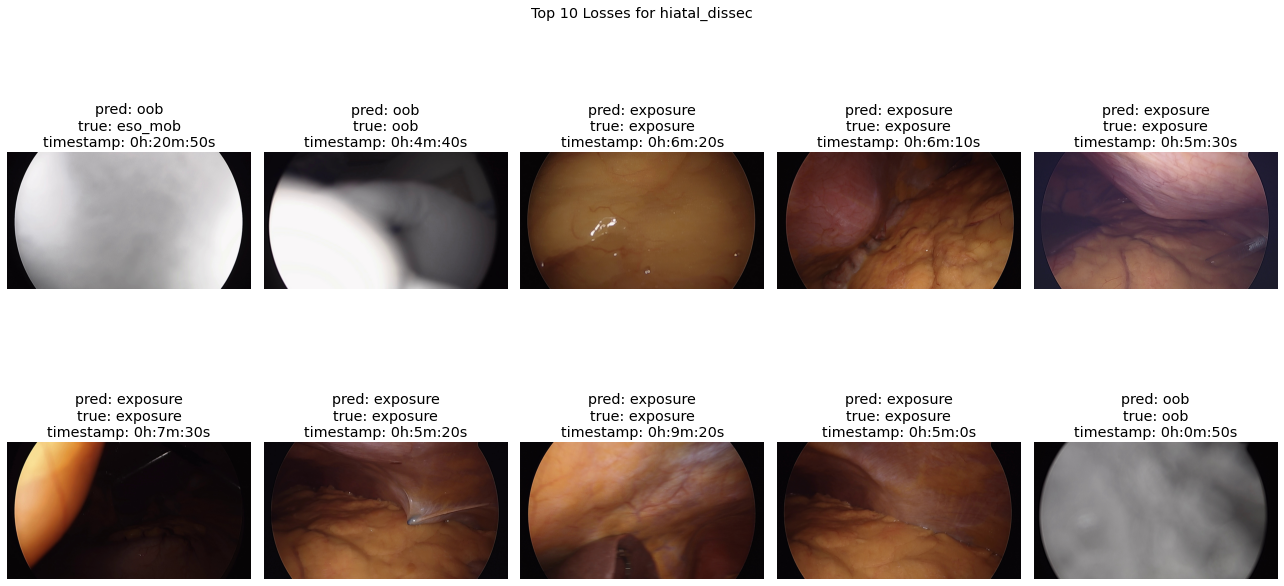

In [63]:
for i in range(10):
    #get the index of the first row
    index = losses1.index[i]
    #get the path of the image
    path = losses1.loc[index]['path']
    #get the predicted label
    pred = preds_df.loc[index]['pred']
    #get the true label
    true = losses1.loc[index]['true']
    #get the timestamp
    time = losses1.loc[index]['time_stamp']
    #show the images on a 2x5 grid, with the phase name as the title
    plt.subplot(2, 5, i+1)
    plt.imshow(plt.imread(path))
    plt.title('pred: ' + pred + '\ntrue: ' + true + '\ntimestamp: ' + time)
    plt.axis('off')
#make the images bigger and more spaced out
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [18, 10]
plt.suptitle('Top 10 Losses for hiatal_dissec')
plt.tight_layout()

In [2]:
def get_timestamp(path):
    path = path.split('/')[5].split('_')[2].split('.')[0]
    time = int(path)
    hr = math.floor(time/3600)
    mint = math.floor((time-hr*3600)/60)
    sec = time - hr*3600 - mint*60
    return (f"{hr}h:{mint}m:{sec}s")

def get_true(path):
    return path.split('/')[4]

def get_top_losses(video):
    my_video = video
    model = tf.keras.models.load_model('../results/models/model_Xception_imagenet_052223.h5')
    test_dir = f'../data/all_frames/{my_video}'
    img_size = 512
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='categorical', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=1, color_mode='rgb')
    cols = os.listdir(test_dir)
    preds_df = pd.DataFrame(columns=cols)
    trues_df = pd.DataFrame(columns=cols)
    # for videos with number of classes < 9, we delete some elements in pred to match the size of label:
    label_name = os.listdir('../data/all_frames/vid_0')
    label_index = [0,1,2,3,4,5,6,7,8]
    label_dict = {label_name[i]: label_index[i] for i in range(len(label_name))}
    keep_list = [label_dict[i] for i in os.listdir(f'../data/all_frames/{my_video}')]
    #for each image in the test dataset, get the predicted probability of each class and the true class and the image path
    count = 0
    for images, labels in test_ds:
        pred = model.predict(images)
        label = labels.numpy()
        pred = pred[0]
        pred = [pred[i] for i in keep_list]
        preds_df.loc[count] = pred
        trues_df.loc[count] = label[0]
        count += 1
    preds_df['path'] = test_ds.file_paths
    trues_df['path'] = test_ds.file_paths
    #calculate accuracy
    preds_mat = preds_df.drop(columns=['path'])
    trues_mat = trues_df.drop(columns=['path'])
    correct_cnt = 0
    for i in range(len(preds_mat)):
        pred = np.argmax((preds_mat.iloc[i]).to_numpy())
        true = np.argmax((trues_mat.iloc[i]).to_numpy())
        if pred==true:
            correct_cnt+=1
    print("accuracy: ", correct_cnt/len(preds_mat))
    #find top losses for each phase, show the image, the predicted label, and the true label
    losses_df = pd.DataFrame(columns=cols)
    for phase in cols:
        #get the predicted probability of each class and the true class for the current phase
        preds = preds_df[phase]
        trues = trues_df[phase]
        #calculate the loss for each image
        losses = np.abs(preds - trues)
        #add the losses to the losses_df
        losses_df[phase] = losses
    losses_df['path'] = preds_df['path']
    preds_df['pred'] = preds_df[trues_df.columns[0:len(preds_df.columns)-1]].idxmax(axis=1)
    for my_phase in os.listdir('../data/all_frames/{}'.format(my_video)):
        losses1 = losses_df.sort_values(by=my_phase, ascending=False)
        losses1 = losses1[[my_phase, 'path']]
        losses1['time_stamp'] = losses1.apply(lambda row: get_timestamp(row['path']) , axis=1)
        losses1['true'] = losses1.apply(lambda row: get_true(row['path']) , axis=1)
        losses1 = losses1.head(10)
        if not os.path.exists('../results/figures/top_losses_by_vid/{}'.format(my_video)):
            os.makedirs('../results/figures/top_losses_by_vid/{}'.format(my_video))
        img_path = f'../results/figures/top_losses_by_vid/{my_video}/{my_phase}_Xception_imagenet_052223.png'
        print(img_path)
        #Plot top 10 losses:
        for i in range(10):
            #get the index of the first row
            index = losses1.index[i]
            #get the path of the image
            path = losses1.loc[index]['path']
            #get the predicted label
            pred = preds_df.loc[index]['pred']
            #get the true label
            true = losses1.loc[index]['true']
            #get the timestamp
            time = losses1.loc[index]['time_stamp']
            #show the images on a 2x5 grid, with the phase name as the title
            plt.subplot(2, 5, i+1)
            plt.imshow(plt.imread(path))
            plt.title('pred: ' + pred + '\ntrue: ' + true + '\ntimestamp: ' + time)
            plt.axis('off')
        #make the images bigger and more spaced out
        plt.rcParams.update({'font.size': 12})
        plt.rcParams['figure.figsize'] = [18, 10]
        plt.suptitle('Top 10 Losses for ' + my_phase)
        plt.tight_layout()
        plt.savefig(img_path,dpi=300, bbox_inches='tight')

Found 583 files belonging to 9 classes.


2023-06-01 00:41:14.727664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [583]
	 [[{{node Placeholder/_4}}]]
2023-06-01 00:41:14.727894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [583]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.7444253859348199
../results/figures/top_losses_by_vid/vid_0/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_0/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_0/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_0/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_0/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_0/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_0/peg_placement_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_0/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_0/wrap_Xception_imagenet_052223.png
Found 613 files belonging to 9 classes.


2023-06-01 00:44:28.014004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [613]
	 [[{{node Placeholder/_0}}]]
2023-06-01 00:44:28.014230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [613]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.8499184339314845
../results/figures/top_losses_by_vid/vid_1/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_1/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_1/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_1/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_1/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_1/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_1/peg_placement_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_1/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_1/wrap_Xception_imagenet_052223.png
Found 542 files belonging to 8 classes.


2023-06-01 00:51:23.808773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [542]
	 [[{{node Placeholder/_4}}]]
2023-06-01 00:51:23.808996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [542]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.7472324723247232
../results/figures/top_losses_by_vid/vid_11/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_11/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_11/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_11/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_11/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_11/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_11/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_11/wrap_Xception_imagenet_052223.png
Found 610 files belonging to 9 classes.


2023-06-01 00:57:19.838739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [610]
	 [[{{node Placeholder/_0}}]]
2023-06-01 00:57:19.838964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [610]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.8590163934426229
../results/figures/top_losses_by_vid/vid_12/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_12/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_12/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_12/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_12/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_12/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_12/peg_placement_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_12/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_12/wrap_Xception_imagenet_052223.png
Found 344 files belonging to 7 classes.


2023-06-01 01:05:10.853337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [344]
	 [[{{node Placeholder/_4}}]]
2023-06-01 01:05:10.853587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [344]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.8284883720930233
../results/figures/top_losses_by_vid/vid_13/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_13/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_13/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_13/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_13/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_13/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_13/wrap_Xception_imagenet_052223.png
Found 419 files belonging to 8 classes.


2023-06-01 01:13:52.155789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [419]
	 [[{{node Placeholder/_4}}]]
2023-06-01 01:13:52.156016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [419]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 21ms/step
accuracy:  0.9498806682577565
../results/figures/top_losses_by_vid/vid_14/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_14/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_14/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_14/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_14/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_14/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_14/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_14/wrap_Xception_imagenet_052223.png
Found 669 files belonging to 8 classes.


2023-06-01 01:26:34.990835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [669]
	 [[{{node Placeholder/_4}}]]
2023-06-01 01:26:34.991056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [669]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9252615844544095
../results/figures/top_losses_by_vid/vid_15/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_15/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_15/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_15/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_15/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_15/peg_placement_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_15/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_15/wrap_Xception_imagenet_052223.png
Found 327 files belonging to 7 classes.


2023-06-01 01:38:28.956413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [327]
	 [[{{node Placeholder/_4}}]]
2023-06-01 01:38:28.956637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [327]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 27ms/step
accuracy:  0.9663608562691132
../results/figures/top_losses_by_vid/vid_16/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_16/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_16/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_16/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_16/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_16/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_16/wrap_Xception_imagenet_052223.png
Found 567 files belonging to 8 classes.


2023-06-01 01:49:23.535961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [567]
	 [[{{node Placeholder/_4}}]]
2023-06-01 01:49:23.536180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [567]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9611992945326279
../results/figures/top_losses_by_vid/vid_17/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_17/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_17/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_17/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_17/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_17/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_17/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_17/wrap_Xception_imagenet_052223.png
Found 597 files belonging to 9 classes.


2023-06-01 02:06:11.652890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [597]
	 [[{{node Placeholder/_4}}]]
2023-06-01 02:06:11.653117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [597]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.8793969849246231
../results/figures/top_losses_by_vid/vid_18/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_18/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_18/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_18/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_18/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_18/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_18/peg_placement_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_18/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_18/wrap_Xception_imagenet_052223.png
Found 481 files belonging to 8 classes.


2023-06-01 02:23:41.444616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [481]
	 [[{{node Placeholder/_4}}]]
2023-06-01 02:23:41.444835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [481]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 21ms/step
accuracy:  0.8918918918918919
../results/figures/top_losses_by_vid/vid_19/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_19/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_19/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_19/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_19/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_19/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_19/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_19/wrap_Xception_imagenet_052223.png
Found 492 files belonging to 8 classes.


2023-06-01 02:43:46.887457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [492]
	 [[{{node Placeholder/_4}}]]
2023-06-01 02:43:46.887679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [492]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9227642276422764
../results/figures/top_losses_by_vid/vid_20/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_20/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_20/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_20/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_20/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_20/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_20/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_20/wrap_Xception_imagenet_052223.png
Found 683 files belonging to 9 classes.


2023-06-01 03:06:50.223271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [683]
	 [[{{node Placeholder/_4}}]]
2023-06-01 03:06:50.223492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [683]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 21ms/step
accuracy:  0.9443631039531479
../results/figures/top_losses_by_vid/vid_21/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_21/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_21/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_21/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_21/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_21/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_21/peg_placement_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_21/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_21/wrap_Xception_imagenet_052223.png
Found 481 files belonging to 8 classes.


2023-06-01 03:30:05.928574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [481]
	 [[{{node Placeholder/_4}}]]
2023-06-01 03:30:05.928796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [481]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9688149688149689
../results/figures/top_losses_by_vid/vid_22/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_22/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_22/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_22/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_22/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_22/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_22/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_22/wrap_Xception_imagenet_052223.png
Found 496 files belonging to 9 classes.


2023-06-01 03:51:36.372321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [496]
	 [[{{node Placeholder/_4}}]]
2023-06-01 03:51:36.372544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [496]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9516129032258065
../results/figures/top_losses_by_vid/vid_23/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_23/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_23/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_23/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_23/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_23/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_23/peg_placement_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_23/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_23/wrap_Xception_imagenet_052223.png
Found 397 files belonging to 8 classes.


2023-06-01 04:16:53.483498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [397]
	 [[{{node Placeholder/_4}}]]
2023-06-01 04:16:53.483716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [397]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9395465994962217
../results/figures/top_losses_by_vid/vid_24/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_24/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_24/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_24/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_24/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_24/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_24/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/vid_24/wrap_Xception_imagenet_052223.png
Found 3 files belonging to 1 classes.


2023-06-01 04:40:29.128275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3]
	 [[{{node Placeholder/_0}}]]
2023-06-01 04:40:29.128520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  1.0
../results/figures/top_losses_by_vid/vid_25/oob_Xception_imagenet_052223.png


IndexError: index 3 is out of bounds for axis 0 with size 3

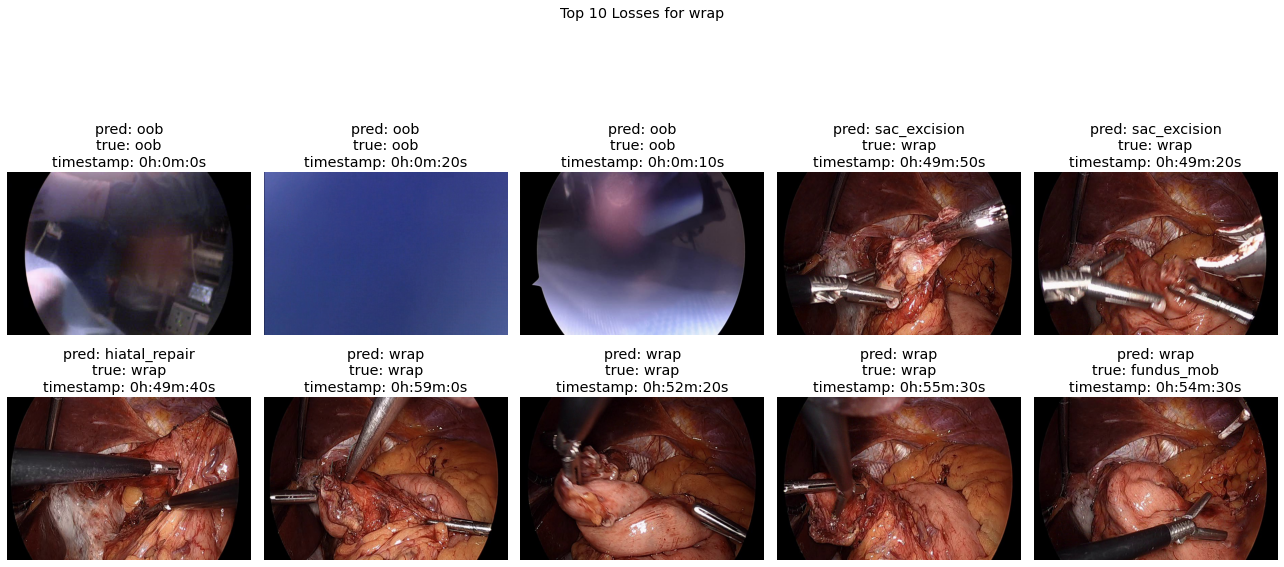

In [41]:
for vid in os.listdir('../data/all_frames'):
    get_top_losses(vid)

2023-06-01 07:36:14.928303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7962 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 2g.10gb, pci bus id: 0000:21:00.0, compute capability: 8.0


Found 336 files belonging to 6 classes.


2023-06-01 07:36:17.047735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [336]
	 [[{{node Placeholder/_4}}]]
2023-06-01 07:36:17.047955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [336]
	 [[{{node Placeholder/_4}}]]
2023-06-01 07:36:18.477522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801


1/1 [==============================] - 2s 2s/step


2023-06-01 07:36:19.191188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 25ms/step
accuracy:  0.36607142857142855
../results/figures/top_losses_by_vid/yale_3/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_3/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_3/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_3/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_3/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_3/wrap_Xception_imagenet_052223.png
Found 334 files belonging to 6 classes.


2023-06-01 07:37:33.406548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [334]
	 [[{{node Placeholder/_0}}]]
2023-06-01 07:37:33.406785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [334]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9251497005988024
../results/figures/top_losses_by_vid/yale_4/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_4/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_4/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_4/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_4/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_4/wrap_Xception_imagenet_052223.png
Found 243 files belonging to 6 classes.


2023-06-01 07:40:02.189091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [243]
	 [[{{node Placeholder/_4}}]]
2023-06-01 07:40:02.189411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [243]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9176954732510288
../results/figures/top_losses_by_vid/yale_5/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_5/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_5/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_5/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_5/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_5/wrap_Xception_imagenet_052223.png
Found 476 files belonging to 7 classes.


2023-06-01 07:43:37.059394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [476]
	 [[{{node Placeholder/_0}}]]
2023-06-01 07:43:37.059654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [476]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.884453781512605
../results/figures/top_losses_by_vid/yale_7/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_7/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_7/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_7/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_7/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_7/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_7/wrap_Xception_imagenet_052223.png
Found 257 files belonging to 6 classes.


2023-06-01 07:49:33.490558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [257]
	 [[{{node Placeholder/_4}}]]
2023-06-01 07:49:33.490815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [257]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9105058365758755
../results/figures/top_losses_by_vid/yale_8/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_8/fundus_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_8/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_8/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_8/sac_excision_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_8/wrap_Xception_imagenet_052223.png
Found 349 files belonging to 6 classes.


2023-06-01 07:55:48.433252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [349]
	 [[{{node Placeholder/_0}}]]
2023-06-01 07:55:48.433472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [349]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9111747851002865
../results/figures/top_losses_by_vid/yale_9/eso_mob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_9/exposure_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_9/hiatal_dissec_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_9/hiatal_repair_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_9/oob_Xception_imagenet_052223.png
../results/figures/top_losses_by_vid/yale_9/wrap_Xception_imagenet_052223.png


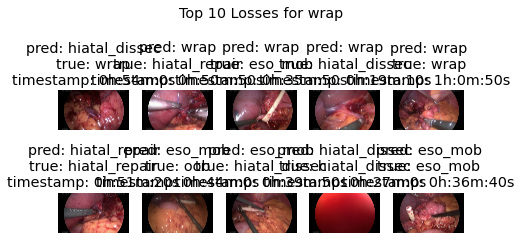

In [3]:
for i in range(31, len(os.listdir('../data/all_frames'))):
    vid = os.listdir('../data/all_frames')[i]
    get_top_losses(vid)

In [22]:
def get_timestamp(path):
    path = path.split('/')[5].split('_')[2].split('.')[0]
    time = int(path)
    hr = math.floor(time/3600)
    mint = math.floor((time-hr*3600)/60)
    sec = time - hr*3600 - mint*60
    return (f"{hr}h:{mint}m:{sec}s")

def get_true(path):
    return path.split('/')[4]

def get_losses_df(video):
    my_video = video
    model = tf.keras.models.load_model('../results/models/model_Xception_imagenet_052223.h5')
    test_dir = f'../data/all_frames/{my_video}'
    img_size = 512
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='categorical', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=1, color_mode='rgb')
    cols = os.listdir(test_dir)
    preds_df = pd.DataFrame(columns=cols)
    trues_df = pd.DataFrame(columns=cols)
    # for videos with number of classes < 9, we delete some elements in pred to match the size of label:
    label_name = os.listdir('../data/all_frames/vid_0')
    label_index = [0,1,2,3,4,5,6,7,8]
    label_dict = {label_name[i]: label_index[i] for i in range(len(label_name))}
    keep_list = [label_dict[i] for i in os.listdir(f'../data/all_frames/{my_video}')]
    #for each image in the test dataset, get the predicted probability of each class and the true class and the image path
    count = 0
    for images, labels in test_ds:
        pred = model.predict(images)
        label = labels.numpy()
        pred = pred[0]
        pred = [pred[i] for i in keep_list]
        preds_df.loc[count] = pred
        trues_df.loc[count] = label[0]
        count += 1
    preds_df['path'] = test_ds.file_paths
    trues_df['path'] = test_ds.file_paths
    #calculate accuracy
    preds_mat = preds_df.drop(columns=['path'])
    trues_mat = trues_df.drop(columns=['path'])
    correct_cnt = 0
    for i in range(len(preds_mat)):
        pred = np.argmax((preds_mat.iloc[i]).to_numpy())
        true = np.argmax((trues_mat.iloc[i]).to_numpy())
        if pred==true:
            correct_cnt+=1
    print("accuracy: ", correct_cnt/len(preds_mat))
    #find top losses for each phase, show the image, the predicted label, and the true label
    losses_df = pd.DataFrame(columns=cols)
    for phase in cols:
        #get the predicted probability of each class and the true class for the current phase
        preds = preds_df[phase]
        trues = trues_df[phase]
        #calculate the loss for each image
        losses = np.abs(preds - trues)
        #add the losses to the losses_df
        losses_df[phase] = losses
    losses_df['path'] = preds_df['path']
    preds_df['pred'] = preds_df[trues_df.columns[0:len(preds_df.columns)-1]].idxmax(axis=1)
    losses_df['time_stamp'] = losses_df.apply(lambda row: get_timestamp(row['path']) , axis=1)
    losses_df['true'] = losses_df.apply(lambda row: get_true(row['path']) , axis=1)
    for my_phase in os.listdir('../data/all_frames/{}'.format(my_video)):
        losses1 = losses_df
        losses1 = losses1.sort_values(by=my_phase, ascending=False)
        losses1 = losses1[[my_phase, 'path', 'time_stamp', 'true']]
        losses1 = losses1[losses1['true']==my_phase]
        losses1 = losses1[losses1[my_phase]>0.5]
        losses1['pred']=np.nan
        for i in range(len(losses1)):
            index= losses1.index[i]
            pred1 = preds_df.loc[index,'pred']
            losses1.loc[index,'pred']=pred1
        if not os.path.exists('../results/losses_df/Xception_losses/{}'.format(my_video)):
            os.makedirs('../results/losses_df/Xception_losses/{}'.format(my_video))
        save_path = f'../results/losses_df/Xception_losses/{my_video}/{my_phase}'
        losses1.to_csv(save_path)

In [23]:
for vid in os.listdir('../data/all_frames'):
    get_losses_df(vid)

Found 583 files belonging to 9 classes.


2023-06-05 21:58:00.146802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [583]
	 [[{{node Placeholder/_0}}]]
2023-06-05 21:58:00.147025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [583]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.7444253859348199
Found 613 files belonging to 9 classes.


2023-06-05 21:58:46.598796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [613]
	 [[{{node Placeholder/_4}}]]
2023-06-05 21:58:46.599017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [613]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.8499184339314845
Found 542 files belonging to 8 classes.


2023-06-05 21:59:32.878911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [542]
	 [[{{node Placeholder/_4}}]]
2023-06-05 21:59:32.879132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [542]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 25ms/step
accuracy:  0.7472324723247232
Found 610 files belonging to 9 classes.


2023-06-05 22:00:12.806287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [610]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:00:12.806505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [610]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 25ms/step
accuracy:  0.8590163934426229
Found 344 files belonging to 7 classes.


2023-06-05 22:00:56.544637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [344]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:00:56.544861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [344]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 27ms/step
accuracy:  0.8284883720930233
Found 419 files belonging to 8 classes.


2023-06-05 22:01:24.961949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [419]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:01:24.962168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [419]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 27ms/step
accuracy:  0.9498806682577565
Found 669 files belonging to 8 classes.


2023-06-05 22:01:59.623970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [669]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:01:59.624228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [669]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 29ms/step
accuracy:  0.9252615844544095
Found 327 files belonging to 7 classes.


2023-06-05 22:02:49.214483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [327]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:02:49.214728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [327]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 25ms/step
accuracy:  0.9663608562691132
Found 567 files belonging to 8 classes.


2023-06-05 22:03:14.764241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [567]
	 [[{{node Placeholder/_0}}]]
2023-06-05 22:03:14.764510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [567]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9611992945326279
Found 597 files belonging to 9 classes.


2023-06-05 22:03:59.117168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [597]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:03:59.117438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [597]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.8793969849246231
Found 481 files belonging to 8 classes.


2023-06-05 22:04:40.284875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [481]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:04:40.285127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [481]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.8918918918918919
Found 492 files belonging to 8 classes.


2023-06-05 22:05:16.728571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [492]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:05:16.728790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [492]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9227642276422764
Found 683 files belonging to 9 classes.


2023-06-05 22:05:54.615867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [683]
	 [[{{node Placeholder/_0}}]]
2023-06-05 22:05:54.616086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [683]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9443631039531479
Found 481 files belonging to 8 classes.


2023-06-05 22:06:41.426652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [481]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:06:41.426896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [481]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9688149688149689
Found 496 files belonging to 9 classes.


2023-06-05 22:07:14.652922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [496]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:07:14.653139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [496]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9516129032258065
Found 397 files belonging to 8 classes.


2023-06-05 22:07:49.564860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [397]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:07:49.565079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [397]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9395465994962217
Found 3 files belonging to 1 classes.


2023-06-05 22:08:18.016902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3]
	 [[{{node Placeholder/_0}}]]
2023-06-05 22:08:18.017115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 25ms/step
accuracy:  1.0
Found 70 files belonging to 2 classes.


2023-06-05 22:08:20.523637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [70]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:08:20.523861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [70]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9714285714285714
Found 403 files belonging to 7 classes.


2023-06-05 22:08:27.758389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [403]
	 [[{{node Placeholder/_0}}]]
2023-06-05 22:08:27.758609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [403]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 29ms/step
accuracy:  0.9503722084367245
Found 445 files belonging to 8 classes.


2023-06-05 22:08:56.198192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [445]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:08:56.198465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [445]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 25ms/step
accuracy:  0.9595505617977528
Found 635 files belonging to 9 classes.


2023-06-05 22:09:30.388667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [635]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:09:30.388920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [635]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9385826771653544
Found 715 files belonging to 9 classes.


2023-06-05 22:10:14.017574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [715]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:10:14.017834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [715]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9132867132867133
Found 296 files belonging to 7 classes.


2023-06-05 22:11:02.853443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [296]
	 [[{{node Placeholder/_0}}]]
2023-06-05 22:11:02.853700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [296]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.8445945945945946
Found 671 files belonging to 4 classes.


2023-06-05 22:11:26.480061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [671]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:11:26.480331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [671]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9225037257824144
Found 196 files belonging to 4 classes.


2023-06-05 22:12:16.525448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [196]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:12:16.525712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [196]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.8673469387755102
Found 321 files belonging to 5 classes.


2023-06-05 22:12:33.077163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [321]
	 [[{{node Placeholder/_0}}]]
2023-06-05 22:12:33.077404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [321]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.956386292834891
Found 306 files belonging to 5 classes.


2023-06-05 22:12:58.605775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [306]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:12:58.605991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [306]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 24ms/step
accuracy:  0.934640522875817
Found 128 files belonging to 5 classes.


2023-06-05 22:13:22.889577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [128]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:13:22.889839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [128]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.9296875
Found 345 files belonging to 6 classes.


2023-06-05 22:13:34.254937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [345]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:13:34.255159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [345]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.927536231884058
Found 291 files belonging to 7 classes.


2023-06-05 22:14:01.605674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [291]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:14:01.605888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [291]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9037800687285223
Found 184 files belonging to 7 classes.


2023-06-05 22:14:24.899605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [184]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:14:24.899861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [184]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.907608695652174
Found 336 files belonging to 6 classes.


2023-06-05 22:14:40.430291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [336]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:14:40.430511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [336]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.36607142857142855
Found 334 files belonging to 6 classes.


2023-06-05 22:15:07.302599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [334]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:15:07.302827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [334]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9251497005988024
Found 243 files belonging to 6 classes.


2023-06-05 22:15:34.004800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [243]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:15:34.005064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [243]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9176954732510288
Found 476 files belonging to 7 classes.


2023-06-05 22:15:54.163321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [476]
	 [[{{node Placeholder/_4}}]]
2023-06-05 22:15:54.163538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [476]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 22ms/step
accuracy:  0.884453781512605
Found 257 files belonging to 6 classes.


2023-06-05 22:16:30.960784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [257]
	 [[{{node Placeholder/_0}}]]
2023-06-05 22:16:30.961011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [257]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9105058365758755
Found 349 files belonging to 6 classes.


2023-06-05 22:16:51.968921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [349]
	 [[{{node Placeholder/_0}}]]
2023-06-05 22:16:51.969171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [349]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 23ms/step
accuracy:  0.9111747851002865
